# Quantum Key Distribution (BB84 Protocol)

## Introduction
Let's say **Alice 💁‍♀️ and Bob 🙋‍♂️** want to set up a secure communication channel, so that they can send private messages to each other without worrying about someone eavesdropping on their conversation.
Unfortunately, it is virtually impossible to set up such a secure channel—there would always be some way of tapping into it and reading their messages.

That's where cryptography comes in! If Alice wants to send a message to Bob, she can encrypt it in some way (say, by replacing every letter in the alphabet with a number). 

$$
A \rightarrow 1 \\
B \rightarrow 2 \\
C \rightarrow 3 \\
\vdots \\
Z \rightarrow 26
$$

If Bob knows exactly how she encoded the message, he can decode it by reversing the encryption (replace every 1 with an $A$, every 2 with a $B$, etc.) However, if **Eve 😈** (or any other eavesdropper) were to  hack their communication channel, they would still have no idea what the message says! It would just look like a string of numbers to them!

Of course, an encryption scheme like this would be pretty easy to crack—Eve could just guess that the numbers correspond to certain letters of the alphabet—but Alice and Bob could always use a more advanced technique instead. Many of these encryption techniques fall under the category of **Symmetric Key Cryptography**, in which each party is given a *key* 🔑 which contains the instructions for encrypting and decrypting the message. In our earlier example, this key would have contained the instructions to replace every letter of the alphabet with it's corresponding index. This key could just be a string of bits (0s and 1s) encoding the instructions for encryption and decryption.

Let's assume that, as long as Alice and Bob share a secret key, they are able to securely encrypt their messages in a way that would be impossible to decrypt without this key. So, if Eve taps into their communication channel and reads their messages, she would have no idea what the messages say, since she would not know the key used to encrypt and decrypt them.

## What is BB84?
Of course, in order to actually set up this encrypted channel, Alice and Bob actually need to communicate in secret to decide what key to use. But this kind of secure communication requires an encrypted channel, which is what we're trying to create in the first place!

Ideally, Alice and Bob could meet up in the real world, and Alice could whisper the key into Bob's ear. But it would be impractical to meet up everytime they wanted to setup a private message channel—imagine if you had to meet someone in person before being able to email them at all!

The BB84 protocol is a method of Quantum Key Distribution which solves this dilemma. If Alice uses this protocol to send a key to Bob, then they can know, with near-perfect certainty, whether the key has been intercepted or not. If it is *not* intercepted, have a secret key that they can use to set up an encrypted channel, so they can communicate freely without worrying about their messages being read by someone else! However, if the key *is* intercepted, they can just repeat the process again and again until they have a key that no one else knows.

However, there are certain requirements for this protocol to work:
* Both Alice and Bob must have access to their own quantum computer.
* They must have a communication channel capable of transmitting qubits. This could be some kind of fibre-optic cable capable of transmitting polarized photons.
* They must have a classical communication channel (like a telephone cable).
Since it is impossible to ensure perfect security, we must assume that any of these channels can be tapped into by Eve the Eavesdropper 😈.

## Overview
Here's how the protocol works in a nutshell:
1. Alice creates a random string of bits, and for each bit, she randomly chooses a basis to encode it in.
2. Alice encodes the bits into qubits using her chosen bases, and sends the qubits over a quantum communication channel to Bob's quantum computer.
3. Bob also randomly chooses a basis to decode each qubit in. He measures each qubit in the bases he chose.
4. Alice uses a classical communication channel to tell Bob which bases she chose. She also tells him the first few bits she sent.
5. Bob analyzes these first few bits to determine whether Eve tapped into their quantum communication channel and intercepted Alice's qubits.
6. If Eve did *not* intercept the qubits, they consider all of the qubits that they happened to choose the same bases for, and use those bits as their key. If Eve *did* intercept the qubits, they repeat the process all over again.

Now, let's break down what each of those steps entails. **First, we'll take a look at how it works if the message is not intercepted by Eve**.

In [1]:
# Importing Qiskit
from qiskit import *
from qiskit.visualization import plot_bloch_multivector
import random

## Encoding
The first step is for Alice to choose a string of bits and bases to encode them in. What do we mean by "bases"?
Well, we can represent a qubit as a vector on a "Bloch Sphere". Each axis can be considered a possible bases. If a vector points directly upward, it is said to be in the state $|0\rangle$, and if it points downward, it is said to be in the state $|1\rangle$. The vertical axis is called the $Z$-axis. In the $Z$-basis, we can encode a 0 as $|0\rangle$ (shown in the image on the left) and a 1 as $|1\rangle$ (shown in the image on the right).

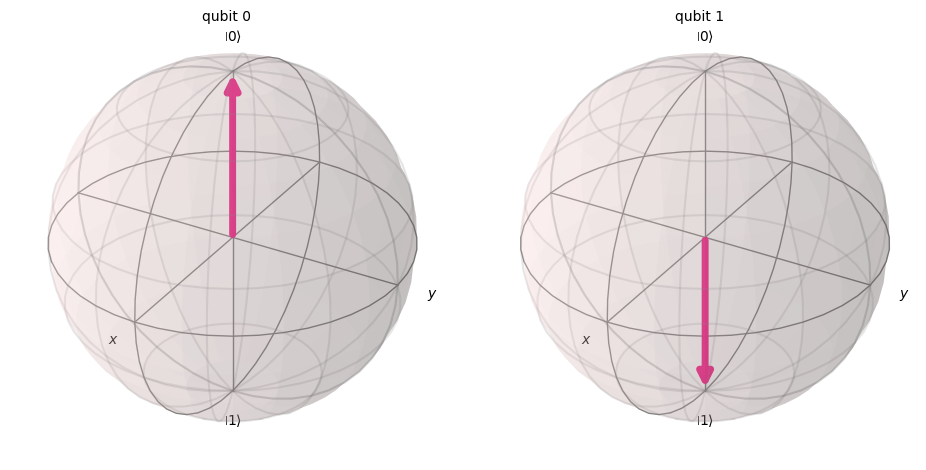

In [2]:
# Ignore this code. This is just used to generate the image mentioned in the previous paragraph.
from qiskit_aer import Aer
qc = QuantumCircuit(2)
qc.x(1)
simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(qc).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

Another basis we can use is the $X$-basis, which lies on the $X$-axis. Here, the image on the left represents the $|+\rangle$ state, which can represent a bit value of 0, and the image on the right represents the $|-\rangle$ state, which can represent a bit value of 1.

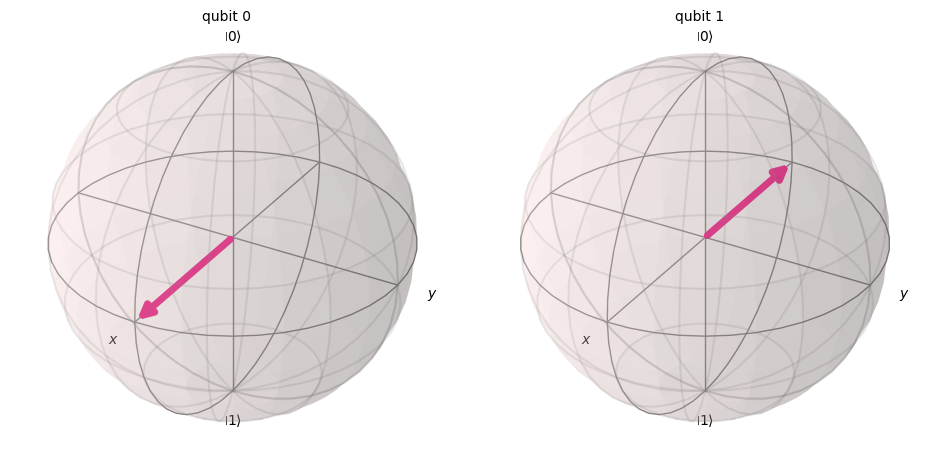

In [5]:
# Ignore this code. This is just used to generate the image mentioned in the previous paragraph.
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.h(1)
simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(qc).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

Now, we have two different ways to encode a 0, and two different ways to encode a 1!

The first step is for Alice to randomly create a string of, say, 500 bits. She can do this by flipping a coin and writing down 0 everytime she lands on heads and 1 everytime she lands on tails.

In [25]:
# Preparation for encoding
KEY_LENGTH = 500
random.seed(0) # Seed the random number generator. This will be used as our "coin flipper".

In [26]:
# Generating a random string of bits
alice_bits = ""
for i in range(KEY_LENGTH):
    randBit = random.randint(0, 1) # Flip Coin
    alice_bits += str(randBit) # Add randomly chosen bit to the bit string.
    
print("The bits Alice is going to send are: " + alice_bits[:10] + "...")

The bits Alice is going to send are: 1101111110...


Then, Alice randomly chooses a basis of each bit (either the $Z$-basis or the $X$-basis). She can do this by flipping a coin and writing down $Z$ everytime she lands on heads and $X$ everytime she lands on tails.

In [27]:
def generate_random_bases(num_of_bases):
    """This function selects a random basis for each bit"""
    bases_string = ""
    for i in range(num_of_bases):
        randBasis = random.randint(0, 1) # Flip Coin

        if randBasis == 0:
            bases_string += "Z" 
        else:
            bases_string += "X"
            
    return bases_string

In [28]:
alice_bases = generate_random_bases(KEY_LENGTH) # Alice randomly chooses a basis for each bit.
    
print("The bases Alice is going to encode them in are: " + alice_bases[:10] + "...")

The bases Alice is going to encode them in are: ZXXZZZZXZX...


Now, Alice encodes each bit into its corresponding basis on her quantum computer, creating a string of 500 qubits. She sends these qubits over an optical cable to Bob. Let's see how to do this using Qiskit.

By default, IBM's quantum computers measure in the $Z$-basis, and all qubits are initialized to $|0\rangle$. To turn this into a $|1\rangle$, we need to apply an $X$ gate.

To encode in the $X$-basis, we start with the corresponding $|0\rangle$ or $|1\rangle$, and then apply a Hadamard (H) gate. This gate converts a $|0\rangle$ into a $|+\rangle$ and a $|1\rangle$ into a $|-\rangle$.

| Bit | Basis | Qubit State | Gate Required |
|:---:|:-----:|:-----------:|:-------------:|
| 0 | Z | $\vert0\rangle$ | None |
| 1 | Z | $\vert1\rangle$ | X |
| 0 | X | $\vert+\rangle$ | H |
| 1 | X | $\vert-\rangle$ | X then H |

We'll store the quantum circuit used to encode each qubit.

In [29]:
def encode(bits, bases):
    """This function encodes each bit into the given basis."""
    
    encoded_qubits = []
    
    for bit, basis in zip(bits, bases):
        qc = QuantumCircuit(1, 1) # Create a quantum circuit for each qubit
        
        # Possible Cases
        if bit=="0" and basis == "Z":
            encoded_qubits.append(qc) # Do not apply any gates

        elif bit=="1" and basis == "Z":
            qc.x(0) # Apply X Gate
            encoded_qubits.append(qc)

        elif bit=="0" and basis == "X":
            qc.h(0) # Apply H Gate
            encoded_qubits.append(qc)

        elif bit=="1" and basis == "X":
            qc.x(0) # Apply X Gate
            qc.h(0) # Apply H Gate
            encoded_qubits.append(qc)
            
    return (encoded_qubits)

In [30]:
# Encode Alice's bits
encoded_qubits = encode(alice_bits, alice_bases)

# Print circuits for first 5 qubits.
for i in range(5):
    print(encoded_qubits[i])
print("etc.")

     ┌───┐
  q: ┤ X ├
     └───┘
c: 1/═════
          
     ┌───┐┌───┐
  q: ┤ X ├┤ H ├
     └───┘└───┘
c: 1/══════════
               
     ┌───┐
  q: ┤ H ├
     └───┘
c: 1/═════
          
     ┌───┐
  q: ┤ X ├
     └───┘
c: 1/═════
          
     ┌───┐
  q: ┤ X ├
     └───┘
c: 1/═════
          
etc.


## Sending the qubits
Normally, Alice would send these encoded qubits over a quantum channel, such as an optical fibre cable. However, since we don't have quantum channels in the real world yet, we'll store the circuits for each qubit in an array called `QUANTUM_CHANNEL` for the sake of demonstration. This would be like if Alice stored the qubits in a building and waited for Bob to pick them up. Of course, just like a fibre optic cable, this building is also a location where Eve might intercept the message.

In [31]:
QUANTUM_CHANNEL = encoded_qubits

## Measurement
The next step is for Bob to receive the encoded qubits and measure them. First, he must choose his own set of random bases, just like Alice.

In [32]:
bob_bases = generate_random_bases(KEY_LENGTH) # Bob randomly chooses a basis for each bit.
    
print("The bases Bob is going to decode them in are: " + bob_bases[:10] + "...")

The bases Bob is going to decode them in are: XZZXZZZXXX...


Then, Bob must measure each Qubit in the corresponding bases he chose. In Qiskit, this can be accomplished by adding a measurement gate to the circuit for each encoded qubit, and then executing it. However, IBM's quantum computers measure in the $Z$-basis by default, so to measure in the $X$-basis, we must apply a Hadamard gate before our measurement gate.

In [33]:
def measure(qubits, bases):
        """This function measures each qubit in the corresponding basis chosen for it."""

        bits = "" # The results of measurements

        for qubit, basis in zip(qubits, bases):

            # Add measurement depending on basis
            if basis == "Z":
                qubit.measure(0, 0)
            elif basis == "X":
                qubit.h(0)
                qubit.measure(0, 0)

            # Execute on Simulator
            simulator = Aer.get_backend('qasm_simulator')
            result = simulator.run(qubit, backend=simulator, shots=1).result()
            counts = result.get_counts()
            measured_bit = max(counts, key=counts.get) # Max doesn't matter for simulator since there is only one shot.

            bits += measured_bit
            
        return bits

In [34]:
qubits_received = QUANTUM_CHANNEL # Receive qubits from quantum channel
bob_bits = measure(qubits_received, bob_bases)

print("The first few bits Bob received are: " + bob_bits[:10] + "...")

The first few bits Bob received are: 0011111100...


# Comparison
Now, Alice needs to tell Bob which bases she chose to encode her qubits in. She can tell him over any classical channel. The beauty of this protocol is that it doesn't matter if Eve finds out which bases Alice used. Alice could even publicly post the list of bases she used on Twitter!

![Alice can even announce it on Twitter!](images/AnnounceBases.png)

In [35]:
CLASSICAL_CHANNEL = alice_bases # Alice tells Bob which bases she used

For each of the qubits where Alice and Bob chose different bases, there is a 50% chance Bob's measurement returned the wrong qubit. For example, If Alice sent Bob a qubit in the $|+\rangle$ state (i.e., a bit value of 0 encoded in the $X$-basis), and Bob measures in the $Z$-basis, there is a 50% chance he will get a $|0\rangle$ and a 50% chance he will get a $|1\rangle$. Thus, every instance where their bases don't match is useless to them, so Bob needs to find the bases they share in common.

In [36]:
# Store the indices of the bases they share in common
common_bases = [i for i in range(KEY_LENGTH) if CLASSICAL_CHANNEL[i]==bob_bases[i]]

print("The indices of the first 10 bases they share in common are: " + str(common_bases[:10]))

The indices of the first 10 bases they share in common are: [4, 5, 6, 7, 9, 10, 11, 19, 22, 24]


Now that Bob knows the bases they share in common, he can discard all the rest of the bits, and only keep the ones that were measured in the same bases.

In [37]:
bob_bits = [bob_bits[index] for index in common_bases]

He also tells Alice which bases they had in common, so that she can discard the rest of the bits as well, keeping only the bits that were measured in the same bases that she encoded them in.

In [38]:
CLASSICAL_CHANNEL = common_bases # Bob tells Alice which bases they shared in common

In [39]:
alice_bits = [alice_bits[index] for index in common_bases] # Alice keeps only the bits they shared in common

Since Alice and Bob are only keeping the bits measured in the bases they shared in common, they *should* have the same bits. To make sure this is the case, Alice will announce the first few bits that she has, and Bob should have the same ones. Of course, if Eve were trying to eavesdrop, she would also hear these first few bits, so Alice and Bob would have to discard them as well (after comparing to make sure they're the same as what they expect).

In [40]:
CLASSICAL_CHANNEL = alice_bits[:100] # Alice tells Bob the first 100 bits she has left.

# Bob checks if they match the first 100 bits that he has
if CLASSICAL_CHANNEL == bob_bits[:100]:
    print("Yep, Alice and Bob seem to have the same bits!")
else:
    print("Uh oh, at least one of the bits is different.")

Yep, Alice and Bob seem to have the same bits!


Since the first 100 bits are the same, Alice and Bob can be fairly certain that the remaining bits also match. Now, they need to discard the first 100 bits, since Eve may have been listening in on the classical channel and keeping track of what they are.

In [41]:
alice_bits = alice_bits[100:] # Alice discards the first 100 bits
bob_bits = bob_bits[100:] # Alice discards the first 100 bits

These remaining bits are the 🔑 key that Alice and Bob need to set up an encrypted communication channel! Now they can communicate without worrying about their messages being read by someone else!

In [44]:
key = "386" 
for bit in alice_bits: # Or bob_bits, since both should be the same
    key += bit

print("Shhhhh, the key is:")
print(str(key))
print("Don't tell anyone!")

print("\nThe key is " + str(len(key)) + " bits long.")

Shhhhh, the key is:
386010101101001011110110100011011001100000111010101000101011101001000110101100111101001101010000111000111000011001110100100000
Don't tell anyone!

The key is 126 bits long.


The length of the key varies depending on how many bases they share in common.

## Interception
___
So far, we've only looked at the case where no one spying on Alice and Bob. But what if someone like Eve tries to intercept their key? Let's see what happens in this case.

First, Alice performs the encoding step as usual: she randomly generates a string of bits and bases to encode them in. She then sends the encoded qubits along a quantum channel (fibre-optic cable) to Bob)

In [45]:
# Generating a random string of bits
alice_bits = ""
for i in range(KEY_LENGTH):
    randBit = random.randint(0, 1) # Flip Coin
    alice_bits += str(randBit) # Add randomly chosen bit to the bit string.
    
# Alice randomly chooses a basis for each bit.
alice_bases = generate_random_bases(KEY_LENGTH)

# Encode Alice's bits
encoded_qubits = encode(alice_bits, alice_bases)

QUANTUM_CHANNEL = encoded_qubits

### ⚠️ Interception by Eve ⚠️
This time, the qubits are intercepted by 😈 Eve. Let's she what she would do. First, she would randomly choose a set of bases to measure the qubits in (since she has no idea which bases Alice used). Then, she'll perform the measurements. This is similar to what Bob would normally do.

In [46]:
qubits_intercepted = QUANTUM_CHANNEL # Intercept qubits
eve_bases = generate_random_bases(KEY_LENGTH) # Generate a random set of bases
eve_bits = measure(qubits_intercepted, eve_bases) # Measure the qubits

Because of the No-Cloning Theorem of Quantum Mechanics, Eve cannot just copy the qubits over from the quantum channel. Thus, Bob will never receive the qubits, making it obvious to him and Alice that their message was intercepted. To prevent them from realizing what has happened, Eve must create her own decoy qubits to send to Bob. Since she has no idea which bases Alice used, she has to generate the bases randomly. This is similar to what Alice originally did when she encoded the qubits. 

Eve might generate an entirely new set of bases, or she might just use the same ones she used to measure the qubits. For simplicity, let's assume the bases she used to intercept the qubits are the same bases she uses to encode her decoy qubits.

In [47]:
# Eve encodes her decoy qubits and sends them along the quantum channel
QUANTUM_CHANNEL = encode(eve_bits, eve_bases)

Bob then performs his usual steps: selecting a measurement bases and measuring the qubits. He doesn't know that Eve has intercepted them yet.

In [48]:
bob_bases = generate_random_bases(KEY_LENGTH) # Bob randomly chooses a basis for each bit.
qubits_received = QUANTUM_CHANNEL # Receive qubits from quantum channel
bob_bits = measure(qubits_received, bob_bases)

### Comparison
Again, Alice needs to tells Bob which bases she chose to encode her qubits in. She can tells him over any classical channel (perhaps even publicly on Twitter). Since this classical channel is public, Eve also knows which bases she used.

In [49]:
CLASSICAL_CHANNEL = alice_bases # Alice tells Bob which bases she used

As usual, Bob checks which bases they share in common. He discards the bits that were not measured in the same bases and keeps the ones that were measured in the same bases Alice encoded them in.

In [50]:
# Store the indices of the bases they share in common
common_bases = [i for i in range(KEY_LENGTH) if CLASSICAL_CHANNEL[i]==bob_bases[i]]
bob_bits = [bob_bits[index] for index in common_bases]

He then tells Alice the indices of the bases they shared in common so that she can do the same.

In [51]:
CLASSICAL_CHANNEL = common_bases # Bob tells Alice which bases they shared in common
alice_bits = [alice_bits[index] for index in common_bases] # Alice keeps only the bits they shared in common

### Waiiiiiiit a Second...
Since Alice and Bob are only keeping the bits measured in the bases they shared in common, they *should* have the same bits. To make sure this is the case, Alice will announce the first few bits that she has, and Bob should have the same ones.

In [52]:
CLASSICAL_CHANNEL = alice_bits[:100] # Alice tells Bob the first 100 bits she has left.

# Bob checks if they match the first 100 bits that he has
if CLASSICAL_CHANNEL == bob_bits[:100]:
    print("Yep, Alice and Bob seem to have the same bits!")
else:
    print("Uh oh, at least one of the bits is different.")

Uh oh, at least one of the bits is different.


After comparing the first 100 bits, they see that their bits don't match! Assuming that their is no noise in the quantum channel and quantum computers (which could cause errors), Alice and Bob can be certain that their message was intercepted! Thus, they can throw away all their bits and repeat the same protocol all over again. This time, they might use a different quantum channel in an effort to throw Eve off!

___
## Sources
* Qiskit Textbook: https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html
* Qubit by Qubit's Introduction to Quantum Computing Course